### Import packages

In [2]:
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import random
import os
import glob
import pandas as pd
import random

import imageio
import imgaug as ia
import imgaug.augmenters as iaa
import ipyplot
import cv2 as cv
from skimage.filters import threshold_otsu, threshold_niblack, threshold_sauvola

from datetime import datetime
from tensorflow.keras.models import model_from_json, Sequential
from tensorflow.keras.callbacks import Callback, CSVLogger, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Activation, Input, concatenate
from tensorflow.keras.layers import Layer, BatchNormalization, Conv2D, MaxPooling2D, Concatenate, Lambda, Flatten, Dense, Dropout
from tensorflow.keras.initializers import glorot_uniform, he_uniform
from tensorflow.keras.regularizers import l2

from sklearn.decomposition import PCA
from sklearn.metrics import roc_curve, roc_auc_score
import math
#from pylab import dist
import json
from PIL import Image

from tensorflow.python.client import device_lib
#import matplotlib.grid_spec as grid_spec

### Fingerprint Enhancement

In [184]:
import numpy as np
import cv2
from scipy import signal
from scipy import ndimage
import math
import scipy

class FingerprintImageEnhancer(object):
    def __init__(self):
        self.ridge_segment_blksze = 16
        self.ridge_segment_thresh = 0.1
        self.gradient_sigma = 1
        self.block_sigma = 7
        self.orient_smooth_sigma = 7
        self.ridge_freq_blksze = 38
        self.ridge_freq_windsze = 5
        self.min_wave_length = 5
        self.max_wave_length = 15
        self.kx = 0.65
        self.ky = 0.65
        self.angleInc = 3
        self.ridge_filter_thresh = -3


        self._mask = []
        self._normim = []
        self._orientim = []
        self._mean_freq = []
        self._median_freq = []
        self._freq = []
        self._freqim = []
        self._binim = []

    def __normalise(self, img, mean, std):
        if(np.std(img) == 0):
            raise ValueError("Image standard deviation is 0. Please review image again")
        normed = (img - np.mean(img)) / (np.std(img))
        return (normed)

    def __ridge_segment(self, img):
        # RIDGESEGMENT - Normalises fingerprint image and segments ridge region
        #
        # Function identifies ridge regions of a fingerprint image and returns a
        # mask identifying this region.  It also normalises the intesity values of
        # the image so that the ridge regions have zero mean, unit standard
        # deviation.
        #
        # This function breaks the image up into blocks of size blksze x blksze and
        # evaluates the standard deviation in each region.  If the standard
        # deviation is above the threshold it is deemed part of the fingerprint.
        # Note that the image is normalised to have zero mean, unit standard
        # deviation prior to performing this process so that the threshold you
        # specify is relative to a unit standard deviation.
        #
        # Usage:   [normim, mask, maskind] = ridgesegment(im, blksze, thresh)
        #
        # Arguments:   im     - Fingerprint image to be segmented.
        #              blksze - Block size over which the the standard
        #                       deviation is determined (try a value of 16).
        #              thresh - Threshold of standard deviation to decide if a
        #                       block is a ridge region (Try a value 0.1 - 0.2)
        #
        # Ouput:     normim - Image where the ridge regions are renormalised to
        #                       have zero mean, unit standard deviation.
        #              mask   - Mask indicating ridge-like regions of the image,
        #                       0 for non ridge regions, 1 for ridge regions.
        #              maskind - Vector of indices of locations within the mask.
        #
        # Suggested values for a 500dpi fingerprint image:
        #
        #   [normim, mask, maskind] = ridgesegment(im, 16, 0.1)
        #
        # See also: RIDGEORIENT, RIDGEFREQ, RIDGEFILTER

        ### REFERENCES

        # Peter Kovesi
        # School of Computer Science & Software Engineering
        # The University of Western Australia
        # pk at csse uwa edu au
        # http://www.csse.uwa.edu.au/~pk
        rows, cols = img.shape
        im = self.__normalise(img, 0, 1)  # normalise to get zero mean and unit standard deviation

        new_rows = int(self.ridge_segment_blksze * np.ceil((float(rows)) / (float(self.ridge_segment_blksze))))
        new_cols = int(self.ridge_segment_blksze * np.ceil((float(cols)) / (float(self.ridge_segment_blksze))))

        padded_img = np.zeros((new_rows, new_cols))
        stddevim = np.zeros((new_rows, new_cols))
        padded_img[0:rows][:, 0:cols] = im
        for i in range(0, new_rows, self.ridge_segment_blksze):
            for j in range(0, new_cols, self.ridge_segment_blksze):
                block = padded_img[i:i + self.ridge_segment_blksze][:, j:j + self.ridge_segment_blksze]

                stddevim[i:i + self.ridge_segment_blksze][:, j:j + self.ridge_segment_blksze] = np.std(block) * np.ones(block.shape)

        stddevim = stddevim[0:rows][:, 0:cols]
        self._mask = stddevim > self.ridge_segment_thresh
        mean_val = np.mean(im[self._mask])
        std_val = np.std(im[self._mask])
        self._normim = (im - mean_val) / (std_val)

    def __ridge_orient(self):
        # RIDGEORIENT - Estimates the local orientation of ridges in a fingerprint
        #
        # Usage:  [orientim, reliability, coherence] = ridgeorientation(im, gradientsigma,...
        #                                             blocksigma, ...
        #                                             orientsmoothsigma)
        #
        # Arguments:  im                - A normalised input image.
        #             gradientsigma     - Sigma of the derivative of Gaussian
        #                                 used to compute image gradients.
        #             blocksigma        - Sigma of the Gaussian weighting used to
        #                                 sum the gradient moments.
        #             orientsmoothsigma - Sigma of the Gaussian used to smooth
        #                                 the final orientation vector field.
        #                                 Optional: if ommitted it defaults to 0
        #
        # Output:    orientim          - The orientation image in radians.
        #                                 Orientation values are +ve clockwise
        #                                 and give the direction *along* the
        #                                 ridges.
        #             reliability       - Measure of the reliability of the
        #                                 orientation measure.  This is a value
        #                                 between 0 and 1. I think a value above
        #                                 about 0.5 can be considered 'reliable'.
        #                                 reliability = 1 - Imin./(Imax+.001);
        #             coherence         - A measure of the degree to which the local
        #                                 area is oriented.
        #                                 coherence = ((Imax-Imin)./(Imax+Imin)).^2;
        #
        # With a fingerprint image at a 'standard' resolution of 500dpi suggested
        # parameter values might be:
        #
        #    [orientim, reliability] = ridgeorient(im, 1, 3, 3);
        #
        # See also: RIDGESEGMENT, RIDGEFREQ, RIDGEFILTER

        ### REFERENCES

        # May 2003      Original version by Raymond Thai,
        # January 2005  Reworked by Peter Kovesi
        # October 2011  Added coherence computation and orientsmoothsigma made optional
        #
        # School of Computer Science & Software Engineering
        # The University of Western Australia
        # pk at csse uwa edu au
        # http://www.csse.uwa.edu.au/~pk

        rows,cols = self._normim.shape
        #Calculate image gradients.
        sze = np.fix(6*self.gradient_sigma)
        if np.remainder(sze,2) == 0:
            sze = sze+1

        gauss = cv2.getGaussianKernel(int(sze),self.gradient_sigma)
        f = gauss * gauss.T

        fy,fx = np.gradient(f)                               #Gradient of Gaussian

        Gx = signal.convolve2d(self._normim, fx, mode='same')
        Gy = signal.convolve2d(self._normim, fy, mode='same')

        Gxx = np.power(Gx,2)
        Gyy = np.power(Gy,2)
        Gxy = Gx*Gy

        #Now smooth the covariance data to perform a weighted summation of the data.
        sze = np.fix(6*self.block_sigma)

        gauss = cv2.getGaussianKernel(int(sze), self.block_sigma)
        f = gauss * gauss.T

        Gxx = ndimage.convolve(Gxx,f)
        Gyy = ndimage.convolve(Gyy,f)
        Gxy = 2*ndimage.convolve(Gxy,f)

        # Analytic solution of principal direction
        denom = np.sqrt(np.power(Gxy,2) + np.power((Gxx - Gyy),2)) + np.finfo(float).eps

        sin2theta = Gxy/denom                   # Sine and cosine of doubled angles
        cos2theta = (Gxx-Gyy)/denom


        if self.orient_smooth_sigma:
            sze = np.fix(6*self.orient_smooth_sigma)
            if np.remainder(sze,2) == 0:
                sze = sze+1
            gauss = cv2.getGaussianKernel(int(sze), self.orient_smooth_sigma)
            f = gauss * gauss.T
            cos2theta = ndimage.convolve(cos2theta,f)                   # Smoothed sine and cosine of
            sin2theta = ndimage.convolve(sin2theta,f)                   # doubled angles

        self._orientim = np.pi/2 + np.arctan2(sin2theta,cos2theta)/2

    def __ridge_freq(self):
        # RIDGEFREQ - Calculates a ridge frequency image
        #
        # Function to estimate the fingerprint ridge frequency across a
        # fingerprint image. This is done by considering blocks of the image and
        # determining a ridgecount within each block by a call to FREQEST.
        #
        # Usage:
        #  [freqim, medianfreq] =  ridgefreq(im, mask, orientim, blksze, windsze, ...
        #                                    minWaveLength, maxWaveLength)
        #
        # Arguments:
        #         im       - Image to be processed.
        #         mask     - Mask defining ridge regions (obtained from RIDGESEGMENT)
        #         orientim - Ridge orientation image (obtained from RIDGORIENT)
        #         blksze   - Size of image block to use (say 32)
        #         windsze  - Window length used to identify peaks. This should be
        #                    an odd integer, say 3 or 5.
        #         minWaveLength,  maxWaveLength - Minimum and maximum ridge
        #                     wavelengths, in pixels, considered acceptable.
        #
        # Output:
        #         freqim     - An image  the same size as im with  values set to
        #                      the estimated ridge spatial frequency within each
        #                      image block.  If a  ridge frequency cannot be
        #                      found within a block, or cannot be found within the
        #                      limits set by min and max Wavlength freqim is set
        #                      to zeros within that block.
        #         medianfreq - Median frequency value evaluated over all the
        #                      valid regions of the image.
        #
        # Suggested parameters for a 500dpi fingerprint image
        #   [freqim, medianfreq] = ridgefreq(im,orientim, 32, 5, 5, 15);
        #

        # See also: RIDGEORIENT, FREQEST, RIDGESEGMENT

        # Reference:
        # Hong, L., Wan, Y., and Jain, A. K. Fingerprint image enhancement:
        # Algorithm and performance evaluation. IEEE Transactions on Pattern
        # Analysis and Machine Intelligence 20, 8 (1998), 777 789.

        ### REFERENCES

        # Peter Kovesi
        # School of Computer Science & Software Engineering
        # The University of Western Australia
        # pk at csse uwa edu au
        # http://www.csse.uwa.edu.au/~pk

        rows, cols = self._normim.shape
        freq = np.zeros((rows, cols))

        for r in range(0, rows - self.ridge_freq_blksze, self.ridge_freq_blksze):
            for c in range(0, cols - self.ridge_freq_blksze, self.ridge_freq_blksze):
                blkim = self._normim[r:r + self.ridge_freq_blksze][:, c:c + self.ridge_freq_blksze]
                blkor = self._orientim[r:r + self.ridge_freq_blksze][:, c:c + self.ridge_freq_blksze]

                freq[r:r + self.ridge_freq_blksze][:, c:c + self.ridge_freq_blksze] = self.__frequest(blkim, blkor)

        self._freq = freq * self._mask
        freq_1d = np.reshape(self._freq, (1, rows * cols))
        ind = np.where(freq_1d > 0)

        ind = np.array(ind)
        ind = ind[1, :]

        non_zero_elems_in_freq = freq_1d[0][ind]

        self._mean_freq = np.mean(non_zero_elems_in_freq)
        self._median_freq = np.median(non_zero_elems_in_freq)  # does not work properly

        self._freq = self._mean_freq * self._mask

    def __frequest(self, blkim, blkor):
        # FREQEST - Estimate fingerprint ridge frequency within image block
        #
        # Function to estimate the fingerprint ridge frequency within a small block
        # of a fingerprint image.  This function is used by RIDGEFREQ
        #
        # Usage:
        #  freqim =  freqest(im, orientim, windsze, minWaveLength, maxWaveLength)
        #
        # Arguments:
        #         im       - Image block to be processed.
        #         orientim - Ridge orientation image of image block.
        #         windsze  - Window length used to identify peaks. This should be
        #                    an odd integer, say 3 or 5.
        #         minWaveLength,  maxWaveLength - Minimum and maximum ridge
        #                     wavelengths, in pixels, considered acceptable.
        #
        # Output:
        #         freqim    - An image block the same size as im with all values
        #                     set to the estimated ridge spatial frequency.  If a
        #                     ridge frequency cannot be found, or cannot be found
        #                     within the limits set by min and max Wavlength
        #                     freqim is set to zeros.
        #
        # Suggested parameters for a 500dpi fingerprint image
        #   freqim = freqest(im,orientim, 5, 5, 15);
        #
        # See also:  RIDGEFREQ, RIDGEORIENT, RIDGESEGMENT

        ### REFERENCES

        # Peter Kovesi
        # School of Computer Science & Software Engineering
        # The University of Western Australia
        # pk at csse uwa edu au
        # http://www.csse.uwa.edu.au/~pk

        rows, cols = np.shape(blkim)

        # Find mean orientation within the block. This is done by averaging the
        # sines and cosines of the doubled angles before reconstructing the
        # angle again.  This avoids wraparound problems at the origin.

        cosorient = np.mean(np.cos(2 * blkor))
        sinorient = np.mean(np.sin(2 * blkor))
        orient = math.atan2(sinorient, cosorient) / 2

        # Rotate the image block so that the ridges are vertical

        # ROT_mat = cv2.getRotationMatrix2D((cols/2,rows/2),orient/np.pi*180 + 90,1)
        # rotim = cv2.warpAffine(im,ROT_mat,(cols,rows))
        rotim = scipy.ndimage.rotate(blkim, orient / np.pi * 180 + 90, axes=(1, 0), reshape=False, order=3,
                                     mode='nearest')

        # Now crop the image so that the rotated image does not contain any
        # invalid regions.  This prevents the projection down the columns
        # from being mucked up.

        cropsze = int(np.fix(rows / np.sqrt(2)))
        offset = int(np.fix((rows - cropsze) / 2))
        rotim = rotim[offset:offset + cropsze][:, offset:offset + cropsze]

        # Sum down the columns to get a projection of the grey values down
        # the ridges.

        proj = np.sum(rotim, axis=0)
        dilation = scipy.ndimage.grey_dilation(proj, self.ridge_freq_windsze, structure=np.ones(self.ridge_freq_windsze))

        temp = np.abs(dilation - proj)

        peak_thresh = 2

        maxpts = (temp < peak_thresh) & (proj > np.mean(proj))
        maxind = np.where(maxpts)

        rows_maxind, cols_maxind = np.shape(maxind)

        # Determine the spatial frequency of the ridges by divinding the
        # distance between the 1st and last peaks by the (No of peaks-1). If no
        # peaks are detected, or the wavelength is outside the allowed bounds,
        # the frequency image is set to 0

        if (cols_maxind < 2):
            return(np.zeros(blkim.shape))
        else:
            NoOfPeaks = cols_maxind
            waveLength = (maxind[0][cols_maxind - 1] - maxind[0][0]) / (NoOfPeaks - 1)
            if waveLength >= self.min_wave_length and waveLength <= self.max_wave_length:
                return(1 / np.double(waveLength) * np.ones(blkim.shape))
            else:
                return(np.zeros(blkim.shape))

    def __ridge_filter(self):
        # RIDGEFILTER - enhances fingerprint image via oriented filters
        #
        # Function to enhance fingerprint image via oriented filters
        #
        # Usage:
        #  newim =  ridgefilter(im, orientim, freqim, kx, ky, showfilter)
        #
        # Arguments:
        #         im       - Image to be processed.
        #         orientim - Ridge orientation image, obtained from RIDGEORIENT.
        #         freqim   - Ridge frequency image, obtained from RIDGEFREQ.
        #         kx, ky   - Scale factors specifying the filter sigma relative
        #                    to the wavelength of the filter.  This is done so
        #                    that the shapes of the filters are invariant to the
        #                    scale.  kx controls the sigma in the x direction
        #                    which is along the filter, and hence controls the
        #                    bandwidth of the filter.  ky controls the sigma
        #                    across the filter and hence controls the
        #                    orientational selectivity of the filter. A value of
        #                    0.5 for both kx and ky is a good starting point.
        #         showfilter - An optional flag 0/1.  When set an image of the
        #                      largest scale filter is displayed for inspection.
        #
        # Output:
        #         newim    - The enhanced image
        #
        # See also: RIDGEORIENT, RIDGEFREQ, RIDGESEGMENT

        # Reference:
        # Hong, L., Wan, Y., and Jain, A. K. Fingerprint image enhancement:
        # Algorithm and performance evaluation. IEEE Transactions on Pattern
        # Analysis and Machine Intelligence 20, 8 (1998), 777 789.

        ### REFERENCES

        # Peter Kovesi
        # School of Computer Science & Software Engineering
        # The University of Western Australia
        # pk at csse uwa edu au
        # http://www.csse.uwa.edu.au/~pk

        im = np.double(self._normim)
        rows, cols = im.shape
        newim = np.zeros((rows, cols))

        freq_1d = np.reshape(self._freq, (1, rows * cols))
        ind = np.where(freq_1d > 0)

        ind = np.array(ind)
        ind = ind[1, :]

        # Round the array of frequencies to the nearest 0.01 to reduce the
        # number of distinct frequencies we have to deal with.

        non_zero_elems_in_freq = freq_1d[0][ind]
        non_zero_elems_in_freq = np.double(np.round((non_zero_elems_in_freq * 100))) / 100

        unfreq = np.unique(non_zero_elems_in_freq)

        # Generate filters corresponding to these distinct frequencies and
        # orientations in 'angleInc' increments.

        sigmax = 1 / unfreq[0] * self.kx
        sigmay = 1 / unfreq[0] * self.ky

        sze = int(np.round(3 * np.max([sigmax, sigmay])))

        x, y = np.meshgrid(np.linspace(-sze, sze, (2 * sze + 1)), np.linspace(-sze, sze, (2 * sze + 1)))

        reffilter = np.exp(-(((np.power(x, 2)) / (sigmax * sigmax) + (np.power(y, 2)) / (sigmay * sigmay)))) * np.cos(
            2 * np.pi * unfreq[0] * x)        # this is the original gabor filter

        filt_rows, filt_cols = reffilter.shape

        angleRange = int(180 / self.angleInc)

        gabor_filter = np.array(np.zeros((angleRange, filt_rows, filt_cols)))

        for o in range(0, angleRange):
            # Generate rotated versions of the filter.  Note orientation
            # image provides orientation *along* the ridges, hence +90
            # degrees, and imrotate requires angles +ve anticlockwise, hence
            # the minus sign.

            rot_filt = scipy.ndimage.rotate(reffilter, -(o * self.angleInc + 90), reshape=False)
            gabor_filter[o] = rot_filt

        # Find indices of matrix points greater than maxsze from the image
        # boundary

        maxsze = int(sze)

        temp = self._freq > 0
        validr, validc = np.where(temp)

        temp1 = validr > maxsze
        temp2 = validr < rows - maxsze
        temp3 = validc > maxsze
        temp4 = validc < cols - maxsze

        final_temp = temp1 & temp2 & temp3 & temp4

        finalind = np.where(final_temp)

        # Convert orientation matrix values from radians to an index value
        # that corresponds to round(degrees/angleInc)

        maxorientindex = np.round(180 / self.angleInc)
        orientindex = np.round(self._orientim / np.pi * 180 / self.angleInc)

        # do the filtering
        for i in range(0, rows):
            for j in range(0, cols):
                if (orientindex[i][j] < 1):
                    orientindex[i][j] = orientindex[i][j] + maxorientindex
                if (orientindex[i][j] > maxorientindex):
                    orientindex[i][j] = orientindex[i][j] - maxorientindex
        finalind_rows, finalind_cols = np.shape(finalind)
        sze = int(sze)
        for k in range(0, finalind_cols):
            r = validr[finalind[0][k]]
            c = validc[finalind[0][k]]

            img_block = im[r - sze:r + sze + 1][:, c - sze:c + sze + 1]

            newim[r][c] = np.sum(img_block * gabor_filter[int(orientindex[r][c]) - 1])

        self._binim = newim < self.ridge_filter_thresh

    def save_enhanced_image(self, path):
        # saves the enhanced image at the specified path
        cv2.imwrite(path, (255 * self._binim))

    def enhance(self, img, resize=True):
        # main function to enhance the image.
        # calls all other subroutines

        if(resize):
            rows, cols = np.shape(img)
            aspect_ratio = np.double(rows) / np.double(cols)

            new_rows = 350                      # randomly selected number
            new_cols = new_rows / aspect_ratio

            img = cv2.resize(img, (int(new_cols), int(new_rows)))

        self.__ridge_segment(img)   # normalise the image and find a ROI
        self.__ridge_orient()       # compute orientation image
        self.__ridge_freq()         # compute major frequency of ridges
        self.__ridge_filter()       # filter the image using oriented gabor filter
        return(self._binim)

### Load the first session Dataset and enhance fingerprints

First session will be split into training and test(validation) data for the model training.

In [62]:
# First session
# Get directory of image data
dir = os.getcwd()
dir = os.path.join(dir,r'Fingerprint Data\contact-based_fingerprints\first_session')

# Iterate through files to get images. There are 336 different fingerprints and 
# each one has 6 pictures of it. The dimension of the picture will be reduced 
# to (w=164,h=178) so final dimension: (6, 336, 178, 164)

images1 = np.empty(shape = (6, 336, 356, 328), dtype = 'float32') # Initialize np array to store images
label = np.empty(shape = (6, 336))
i=0
for image in os.listdir(dir):
    path = 'Fingerprint Data\\contact-based_fingerprints\\first_session' + '\\' + image
    im = cv.imread(path, cv.IMREAD_GRAYSCALE) # Read grayscale image
    
    # Contrast Limited Adaptive Histogram Equalization
    clahe = cv.createCLAHE(clipLimit=20, tileGridSize=(100,100))
    cl = clahe.apply(np.uint8(im))
    
    # Niblack binarization filter
    nib_thr = threshold_niblack(cl, window_size=21, k=0.1)
    nib = cl > nib_thr
    
    # Create FingerprintImageEnhancer object and enhance image
    image_enhancer = FingerprintImageEnhancer()
    nib = image_enhancer.enhance(nib)
    nib = nib*255 # nib was a True/False array
    
    tag = int(image.split('_')[0])            # Get first number of image name (finger id)
    ind = int(image.split('_')[1][0])         # Get second number of image name (# finger picture)
    
    images1[ind-1, i, :, :] = nib
    label[ind-1, i] = tag
    if ind==6:
        i+=1
images1.shape     

(6, 336, 356, 328)

In [79]:
x_train = images1[:, 0:300, :, :]
y_train = label[:, 0:300]
x_test = images1[:, 300:, :, :]
y_test = label[:, 300:]

np.savez_compressed('fingers_poly.npz', x_train = x_train, y_train = y_train, x_test = x_test, y_test = y_test)

In [3]:
loaded = np.load('fingers_poly.npz')
x_train, y_train, x_test, y_test = loaded['x_train'], loaded['y_train'], loaded['x_test'], loaded['y_test']

### Load the second session Dataset and enhance fingerprints

This data will be used to evaluate the model after it is done training.

In [100]:
# Second session
# Get directory of image data
dir = os.getcwd()
dir = os.path.join(dir,r'Fingerprint Data\contact-based_fingerprints\second_session')

# Iterate through files to get images. There are 160 different fingerprints and 
# each one has 6 pictures of it. The dimension of the picture will be reduced 
# to (w=164,h=178) so final dimension: (6, 160, 178, 164)

images2 = np.empty(shape = (6, 160, 356, 328), dtype = 'float32') # Initialize np array to store images
label = np.empty(shape = (6, 160))
i=0
k=0
for image in os.listdir(dir):
    path = 'Fingerprint Data\\contact-based_fingerprints\\second_session' + '\\' + image
    im = cv.imread(path, cv.IMREAD_GRAYSCALE) # Read grayscale image

    # Contrast Limited Adaptive Histogram Equalization
    clahe = cv.createCLAHE(clipLimit=20, tileGridSize=(100,100))
    cl = clahe.apply(np.uint8(im))
    
    # Niblack binarization filter
    nib_thr = threshold_niblack(cl, window_size=21, k=0.1)
    nib = cl > nib_thr
    
    # Create FingerprintImageEnhancer object and enhance image
    image_enhancer = FingerprintImageEnhancer()
    nib = image_enhancer.enhance(nib)
    nib = nib*255 # nib was a True/False array
    
    tag = int(image.split('_')[0])            # Get first number of image name (finger id)
    ind = int(image.split('_')[1][0])         # Get second number of image name (# finger picture)
    images2[ind-1, i, :, :] = nib
    label[ind-1, i] = tag
    if ind==6:
        i+=1
    
images2.shape 

(6, 160, 356, 328)

In [102]:
x_eval = images2
y_eval = label

np.savez_compressed('fingers_poly_eval.npz', x_eval = x_eval, y_eval = y_eval)

In [187]:
loaded = np.load('fingers_poly_eval.npz')
x_eval = loaded['x_eval']
y_eval = loaded['y_eval']

### Create the triplets

Two functions will be implemented. create_batch will randomly select triplets from the dataset. create_hard_batch will add some semi-hard triplets to every batch. Semi-hard triplets are the ones where the negative example is farther away from the anchor than the positive example but still produces positive loss.

In [4]:
def create_batch(batch_size = 32, split = 'train'):
    
    x_anchors = np.zeros((batch_size, x_train.shape[2], x_train.shape[3]))   ### All three are of size (32,100,160)
    x_positives = np.zeros((batch_size, x_train.shape[2], x_train.shape[3]))
    x_negatives = np.zeros((batch_size, x_train.shape[2], x_train.shape[3]))
    
    if split =="train":
        data = x_train
        data_y = y_train
    else:
        data = x_test
        data_y = y_test
    
    for i in range(0, batch_size):
        # Find an anchor, a positive (augmentation from the same finger) and a negative example.
        # anchor
        rand_finger = random.randint(0, data.shape[1] - 1) # Choose a finger randomly
        x_anchor = data[0, rand_finger, :, :]
        
        # positive
        rand_aug = random.randint(1, 5)                    # Choose a random augmentation of it
        while np.all(data[rand_aug, rand_finger, :, :] == np.zeros(shape=(x_train.shape[2],x_train.shape[3]))):
            rand_aug = random.randint(1, 5)
        x_positive = data[rand_aug, rand_finger, :, :]
        
        # negative
        rand_neg = random.randint(0, data.shape[1] - 1)    # Choose a random negative finger DIFFERENT than the anchor
        while rand_neg == rand_finger:
            rand_neg = random.randint(0, data.shape[1] - 1)
        x_negative = data[0, rand_neg, :, :]
        
        x_anchors[i, :, :] = x_anchor
        x_positives[i, :, :] = x_positive
        x_negatives[i, :, :] = x_negative
        
    return [x_anchors, x_positives, x_negatives]

In [5]:
def create_hard_batch(batch_size, num_hard, split = 'train'):
    
    x_anchors = np.zeros((batch_size, x_train.shape[2], x_train.shape[3]))   ### All three are of size (32,100,160)
    x_positives = np.zeros((batch_size, x_train.shape[2], x_train.shape[3]))
    x_negatives = np.zeros((batch_size, x_train.shape[2], x_train.shape[3]))
    
    if split =="train":
        data = x_train
        data_y = y_train
    else:
        data = x_test
        data_y = y_test
    
    # Generate num_hard number of hard examples
    hard_batches = []
    batch_losses = []
    
    rand_batches = []
    
    # Get some random batches
    for i in range(0, batch_size):
        hard_batches.append(create_batch(1, split)) # Returns only one triplet
        
        A_emb = embedding_model.predict(hard_batches[i][0])
        P_emb = embedding_model.predict(hard_batches[i][1])
        N_emb = embedding_model.predict(hard_batches[i][2])
        
        # Compute distance for each selected batch
        batch_losses.append(np.sum(np.square(A_emb - P_emb), axis = 1) - np.sum(np.square(A_emb - N_emb), axis = 1))
        
    # Sort batch_loss by distance, highest first, and keep num_hard of them
    
    # Semi-hard require dist(A,N) > dist(A,P) AND still positive loss so
    # I choose the hard batches based on batch loss ascending order. The line
    # below creates zip/pairs of batch_losses, hard_batches and returns ONLY
    # the hard batches (_,x) having sorted in ascending order the batch loss (x[0]).
    
    hard_batch_selections = [x for _, x in sorted(zip(batch_losses, hard_batches), key = lambda x: x[0])]
    hard_batches = hard_batch_selections[:num_hard]
    
    # Get batch_size - num_hard number of random examples
    num_rand = batch_size - num_hard
    for i in range(0, num_rand):
        rand_batch = create_batch(1, split)
        rand_batches.append(rand_batch)
        
    selections = hard_batches + rand_batches
    
    for i in range(0, len(selections)):
        x_anchors[i, :, :] = selections[i][0]
        x_positives[i, :, :] = selections[i][1]
        x_negatives[i, :, :] = selections[i][2]
        
    return [x_anchors, x_positives, x_negatives]

### The SNN

The SNN is defined in two parts. First the embedding model: Input: image, Output: d-dimensional embedding. Then a model takes a triplet and passes it sequentially through the embedding model to generate 3 embeddings which are then fed into the triplet loss function.

In [6]:
def create_embedding_model(emb_size):
    
    embedding_model = tf.keras.models.Sequential()
    
    embedding_model.add(Conv2D(filters = 32, kernel_size = (3,3), strides = (1,1), padding = 'same', 
                     activation = 'relu', kernel_initializer='he_uniform',
                     kernel_regularizer=tf.keras.regularizers.l2(0.001), input_shape = (x_train.shape[2] , x_train.shape[3] , 1)))
    
    embedding_model.add(BatchNormalization())
    
    embedding_model.add(MaxPooling2D(pool_size = (2,2), strides = (2,2))) # output: (89,82,32)
    
    embedding_model.add(Conv2D(filters = 64, kernel_size = (3,3), strides = (1,1), padding = 'same', 
                     activation = 'relu', kernel_initializer='he_uniform',
                     kernel_regularizer=tf.keras.regularizers.l2(0.001)))
    
    embedding_model.add(BatchNormalization())
    
    embedding_model.add(MaxPooling2D(pool_size = (2,2), strides = (2,2))) # output: (44,41,64)
    
    embedding_model.add(Conv2D(filters = 128, kernel_size = (3,3), strides = (1,1), padding = 'same', 
                     activation = 'relu', kernel_initializer='he_uniform',
                     kernel_regularizer=tf.keras.regularizers.l2(0.001)))
    
    embedding_model.add(BatchNormalization())
    
    embedding_model.add(MaxPooling2D(pool_size = (2,2), strides = (2,2))) # output: (22,20,128)
    
    embedding_model.add(Conv2D(filters = 256, kernel_size = (3,3), strides = (1,1), padding = 'same', 
                     activation = 'relu', kernel_initializer='he_uniform',
                     kernel_regularizer=tf.keras.regularizers.l2(0.001)))
    
    embedding_model.add(BatchNormalization())
    
    embedding_model.add(MaxPooling2D(pool_size = (2,2), strides = (2,2))) # output: (11,10,256)
    
    embedding_model.add(Dropout(rate = 0.3))
    
    embedding_model.add(Flatten()) # output: 11*10*256
    
    embedding_model.add(Dense(units = 512, activation = 'relu', kernel_initializer='he_uniform',
             kernel_regularizer=tf.keras.regularizers.l2(1e-3)))
    
    embedding_model.add(Dense(units = 256, activation = 'relu', kernel_initializer='he_uniform',
             kernel_regularizer=tf.keras.regularizers.l2(1e-3)))
    
    # output layer with embedding_size no of units
    embedding_model.add(Dense(units = emb_size, activation = None, kernel_initializer='he_uniform',
             kernel_regularizer=tf.keras.regularizers.l2(1e-3)))
    
    # Force the embedding to live on the d-dimentional hypershpere
    embedding_model.add(Lambda(lambda x: tf.keras.backend.l2_normalize(x, axis=-1)))
    
    embedding_model.summary()
    
    return embedding_model

In [7]:
def create_SNN(embedding_model):
    
    input_anchor = Input(shape = (x_train.shape[2] , x_train.shape[3] ,))
    input_positive = Input(shape = (x_train.shape[2] , x_train.shape[3] ,))
    input_negative = Input(shape = (x_train.shape[2] , x_train.shape[3] ,))
    
    embedding_anchor = embedding_model(input_anchor)
    embedding_positive = embedding_model(input_positive)
    embedding_negative = embedding_model(input_negative)
    
    output = concatenate([embedding_anchor, embedding_positive, embedding_negative], axis = 1)
    
    siamese_net = tf.keras.models.Model(inputs = [input_anchor, input_positive, input_negative],
                                        outputs = output)
    
    siamese_net.summary()
    
    return siamese_net

### Triplet Loss function

In order for the SNN to train using the triplets, we need to define the triplet loss function

In [8]:
def triplet_loss(y_true, y_pred):
    anchor, positive, negative = y_pred[:, :emb_size], y_pred[:, emb_size:2*emb_size], y_pred[:, 2*emb_size:]
    positive_dist = tf.reduce_mean(tf.square(anchor - positive), axis = 1)
    negative_dist = tf.reduce_mean(tf.square(anchor - negative), axis = 1)
    tr_loss = tf.maximum(positive_dist - negative_dist + alpha, 0.)
    return tr_loss

### Data generator

In order to pass the triplets to the network, we need to create a data generator function. Both an x and y is required here by TensorFlow, but we don’t need a y value, so we pass a filler.

In [9]:
def data_generator(batch_size = 32, num_hard = 16, split = 'train'):
    while True:
        x = create_hard_batch(batch_size, num_hard)
        y = np.zeros((batch_size, 3*emb_size))
        yield x, y

### Setup for training and evaluation

1. Define hyperparameters
2. Compile models

Once the models are compiled, we store a subset of the test image embeddings. The model hasn’t been trained yet, so this gives us a good baseline to show how the embeddings have changed through the training process.

In [10]:
batch_size = 32
epochs = 100
steps_per_epoch = 50 # int(x_train.shape[0]*x_train.shape[1]/batch_size)
val_steps = 20 #int(x_test.shape[0]*x_test.shape[1]/batch_size)
alpha = 0.3
num_hard = 16 # Number of semi-hard triplet examples in the batch
lr = 0.0001
optimiser = 'Adam'
emb_size = 128

with tf.device('/cpu:0'):
    # Create the embedding model
    print('Generating embedding model... \n')
    embedding_model = create_embedding_model(emb_size)
    
    print('\n Generating SNN... \n')
    # Create the SNN
    siamese_net = create_SNN(embedding_model)
    # Compile the SNN
    optimiser_obj = Adam(lr = lr)
    siamese_net.compile(loss = triplet_loss, optimizer = optimiser_obj)

Generating embedding model... 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 356, 328, 32)      320       
                                                                 
 batch_normalization (BatchN  (None, 356, 328, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 178, 164, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 178, 164, 64)      18496     
                                                                 
 batch_normalization_1 (Batc  (None, 178, 164, 64)     256       
 hNormalization)                                                 
                        

### ROC-AUC

Further evaluation on untrained model to compare later the ROC curve of the trained model.

5/5 [==============================] - 10s 2s/step


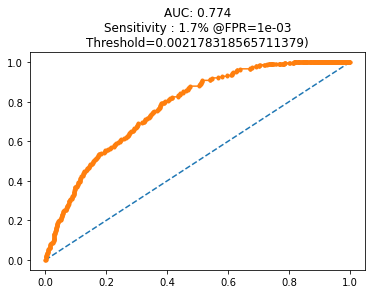

In [210]:
X = np.empty(shape = (160, 356, 328), dtype = 'float32')
Y = np.empty(shape = (160,), dtype = 'float32')
seq = [*range(160)]
ind = random.sample(seq, 40)
for i in range(40):
    X[i*4, :, :] = x_eval[0, ind[i], :, :]
    X[i*4 + 1, :, :] = x_eval[3, ind[i], :, :]
    X[i*4 + 2, :, :] = x_eval[2, ind[i], :, :]
    X[i*4 + 3, :, :] = x_eval[5, ind[i], :, :]
    Y[i*4:(i+1)*4] = y_eval[0, ind[i]]
    
    
X = np.expand_dims(X, axis=-1)
def compute_dist(a, b):
    return np.linalg.norm(a-b)


def compute_probs(network, X, Y):
    '''
    Input
        network : current NN to compute embeddings
        X : tensor of shape (m,w,h,1) containing pics to evaluate
        Y : tensor of shape (m,) containing true class
        
    Returns
        probs : array of shape (m,m) contaning distances
    '''
    
    m = X.shape[0]
    nbevaluation = int(m*(m-1)/2)
    probs = np.zeros((nbevaluation))
    y = np.zeros((nbevaluation))
    
    #Compute all embeddings for all images with current embedding network
    embeddings = embedding_model.predict(X)
    
    k = 0
    
    # For each image in the evaluation set
    for i in range(m):
        # Against all other images
        for j in range(i+1,m):
            # compute the probability of being the right decision
            # it should be 1 for right class, 0 for all other classes
            probs[k] = -compute_dist(embeddings[i,:],embeddings[j,:])
            if (Y[i]==Y[j]):
                y[k] = 1
            else:
                y[k] = 0
            k += 1
    
    return probs, y


def compute_metrics(probs, yprobs):
    '''
    Returns
        fpr : Increasing false positive rates such that element i is the false positive rate
              of predictions with score >= thresholds[i]
        tpr : Increasing true positive rates such that element i is the true positive rate
              of predictions with score >= thresholds[i].
        thresholds : Decreasing thresholds on the decision function used to compute fpr and tpr.
                     thresholds[0] represents no instances being predicted and is arbitrarily
                     set to max(y_score) + 1
        auc : Area Under the ROC Curve metric
    '''
    
    # Calculate AUC
    auc = roc_auc_score(yprobs, probs)
    # calculate roc curve
    fpr, tpr, thresholds = roc_curve(yprobs, probs)
    
    return fpr, tpr, thresholds, auc


def draw_roc(fpr, tpr, thresholds, auc):
    
    #find threshold
    targetfpr = 1e-3
    _, idx = find_nearest(fpr, targetfpr)
    threshold = thresholds[idx]
    recall = tpr[idx]
    
    
    # plot no skill
    plt.plot([0, 1], [0, 1], linestyle='--')
    # plot the roc curve for the model
    plt.plot(fpr, tpr, marker='.')
    plt.title('AUC: {0:.3f}\nSensitivity : {2:.1%} @FPR={1:.0e}\nThreshold={3})'.format(auc,targetfpr,recall,abs(threshold) ))
    # show the plot
    plt.show()
    
    
def find_nearest(array,value):
    
    idx = np.searchsorted(array, value, side="left")
    
    if idx > 0 and (idx == len(array) or math.fabs(value - array[idx-1]) < math.fabs(value - array[idx])):
        return array[idx-1],idx-1
    else:
        return array[idx],idx

            
def evaluate(embedding_model, X, Y, epochs = 0):
    probs,yprob = compute_probs(embedding_model, X, Y)
    fpr, tpr, thresholds, auc = compute_metrics(probs,yprob)
    draw_roc(fpr, tpr, thresholds, auc)

evaluate(embedding_model, X, Y)

### Logging output from our model training

In [38]:
# Set up logging directory
# Use date-time as logdir name:
#dt = datetime.now().strftime("%Y%m%dT%H%M")
#logdir = os.path.join("PATH/TO/LOG",dt)

## Use a custom non-dt name:
name = "my_snn-article-example-run"
logdir = os.path.join(r'C:\Users\giorg\OneDrive\Υπολογιστής\Python scripts\Fingerprint recognition notebook',name)

if not os.path.exists(logdir):
    os.mkdir(logdir)
    
# Callbacks:
# Create the TensorBoard callback
tensorboard = tf.keras.callbacks.TensorBoard(
    log_dir = logdir,
    histogram_freq=0,
    batch_size=batch_size,
    write_graph=True,
    write_grads=True, 
    write_images = True, 
    update_freq = 'epoch', 
    profile_batch=0
)

# Training logger
csv_log = os.path.join(logdir, 'training.csv')
csv_logger = CSVLogger(csv_log, separator=',', append=True)

# Only save the best model weights based on the val_loss
checkpoint = ModelCheckpoint(os.path.join(logdir, 'snn_model-{epoch:02d}-{val_loss:.2f}.h5'),
                             monitor='val_loss', verbose=1,
                             save_best_only=True, save_weights_only=True, 
                             mode='auto')

# Save the embedding model weights based on the main model's val loss
# This is needed to recreate the emebedding model should we wish to visualise
# the latent space at the saved epoch

class SaveEmbeddingModelWeights(Callback):
    def __init__(self, filepath, monitor='val_loss', verbose=1):
        super(Callback, self).__init__()
        self.monitor = monitor
        self.verbose = verbose
        self.best = np.Inf
        self.filepath = filepath

    def on_epoch_end(self, epoch, logs={}):
        current = logs.get(self.monitor)
        if current is None:
            warnings.warn("SaveEmbeddingModelWeights requires %s available!" % self.monitor, RuntimeWarning)

        if current < self.best:
            filepath = self.filepath.format(epoch=epoch + 1, **logs)
            if self.verbose == 1:
                print("Saving embedding model weights at %s" % filepath)
            embedding_model.save_weights(filepath, overwrite = True)
            self.best = current
            
            # Delete the last best emb_model and snn_model
            delete_older_model_files(filepath)
            
# Save the embedding model weights if you save a new snn best model based on the model checkpoint above
emb_weight_saver = SaveEmbeddingModelWeights(os.path.join(logdir, 'emb_model-{epoch:02d}.h5'))

callbacks = [tensorboard, csv_logger, checkpoint, emb_weight_saver]

# Save model configs to JSON
model_json = siamese_net.to_json()
with open(os.path.join(logdir, "siamese_config.json"), "w") as json_file:
    json_file.write(model_json)
    json_file.close()
    
model_json = embedding_model.to_json()
with open(os.path.join(logdir, "embedding_config.json"), "w") as json_file:
    json_file.write(model_json)
    json_file.close()
    
hyperparams = {'batch_size' : batch_size,
              'epochs' : epochs, 
               'steps_per_epoch' : steps_per_epoch, 
               'val_steps' : val_steps, 
               'alpha' : alpha, 
               'num_hard' : num_hard, 
               'optimiser' : optimiser,
               'lr' : lr,
               'emb_size' : emb_size
              }

with open(os.path.join(logdir, "hyperparams.json"), "w") as json_file:
    json.dump(hyperparams, json_file)
    
# Set the model to TB
tensorboard.set_model(siamese_net)

def delete_older_model_files(filepath):
    
    model_dir = filepath.split("emb_model")[0]
    
    # Get model files
    model_files = os.listdir(model_dir)
    # Get only the emb_model files
    emb_model_files = [file for file in model_files if "emb_model" in file]
    # Get the epoch nums of the emb_model_files
    emb_model_files_epoch_nums = [file.split("-")[1].split(".h5")[0] for file in emb_model_files]

    # Find all the snn model files
    snn_model_files = [file for file in model_files if "snn_model" in file]

    # Sort, get highest epoch num
    emb_model_files_epoch_nums.sort()
    highest_epoch_num = emb_model_files_epoch_nums[-1]

    # Filter the emb_model and snn_model file lists to remove the highest epoch number ones
    emb_model_files_without_highest = [file for file in emb_model_files if highest_epoch_num not in file]
    snn_model_files_without_highest = [file for file in snn_model_files if highest_epoch_num not in file]

    # Delete the non-highest model files from the subdir
    if len(emb_model_files_without_highest) != 0:
        print("Deleting previous best model file:", emb_model_files_without_highest)
        for model_file_list in [emb_model_files_without_highest, snn_model_files_without_highest]:
            for file in model_file_list:
                os.remove(os.path.join(model_dir, file))

## Training the SNN

In [ ]:
# siamese_net is already compiled

siamese_history = siamese_net.fit(
    data_generator(batch_size, num_hard),
    steps_per_epoch = steps_per_epoch,
    epochs = epochs,
    verbose = 2,
    callbacks = callbacks,
    workers = 0,
    validation_data = data_generator(batch_size, num_hard, split = 'test'),
    validation_steps = val_steps)

print('-------------------------------------------')
print('Training complete')

## Evaluate model at second session test data

In [11]:
embedding_model.save('untrained_model.h5')

In [241]:
embedding_model.load_weights('CustomCNN_final/emb_model-95.h5')

In [207]:
X = np.empty(shape = (160, 356, 328), dtype = 'float32')
Y = np.empty(shape = (160,), dtype = 'float32')
seq = [*range(160)]
ind = random.sample(seq, 40)
for i in range(40):
    X[i*4, :, :] = x_eval[0, ind[i], :, :]
    X[i*4 + 1, :, :] = x_eval[3, ind[i], :, :]
    X[i*4 + 2, :, :] = x_eval[2, ind[i], :, :]
    X[i*4 + 3, :, :] = x_eval[5, ind[i], :, :]
    Y[i*4:(i+1)*4] = y_eval[0, ind[i]]
    
X = np.expand_dims(X, axis=-1)

5/5 [==============================] - 11s 2s/step


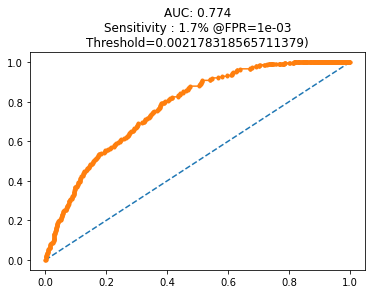

In [211]:
evaluate(embedding_model, X, Y)

In [172]:
#embedding_model.load_weights('snn-article-example-run_1/emb_model-41.h5')
num_test = 10
X = np.empty(shape = (num_test, 178, 164, 1), dtype = 'float32')
Y = np.empty(shape = (num_test,), dtype = 'float32')
seq = [*range(160)]
ind = random.sample(seq, int(num_test/2))
for i in range(int(num_test/2)):
    X[i*2, :, :, 0] = x_eval[2, ind[i], :, :]
    X[2*i+1, :, :, 0] = x_eval[3, ind[i], :, :]
    Y[2*i:2*i+2] = i+1

scores = []
for i in range(0,10):
    temp = X[i,:,:,0]
    temp = np.expand_dims(temp, axis = -1)
    temp = np.expand_dims(temp, axis = 0)
    res = embedding_model.predict(temp)
    scores.append(res)

matrix = np.empty(shape = (num_test,num_test))
for i in range(0,num_test):
    for j in range(0,num_test):
        matrix[i,j] = np.linalg.norm(scores[i]-scores[j])

matrix = matrix*100

df = pd.DataFrame(data = matrix, index = Y, columns = Y)

save = []
count = 0
tot = num_test*(num_test-2)
for j in range(num_test):
    arr = matrix[:,j]
    ind = np.argmin(arr)
    if j%2 == 0:
        ind = ind + 1
    else:
        ind = ind - 1
    save.append(arr[ind])
    for i in range(num_test):
        if (arr[i] != 0) & (arr[i] != arr[ind]) & (arr[ind] < arr[i]):
            count+=1
print(f'Percentage:',count/tot*100,'%')
print([round(item, 3) for item in save])
df

1/1 [==============================] - 0s 53ms/step
Percentage: 85.0 %
[0.138, 0.138, 0.303, 0.303, 0.133, 0.133, 0.198, 0.198, 0.117, 0.117]


,1.0,1.0,2.0,2.0,3.0,3.0,4.0,4.0,5.0,5.0
1.0,0.000000,0.137737,0.357310,0.072031,0.177001,0.055502,0.982667,1.177546,0.246946,0.358082
1.0,0.137737,0.000000,0.491840,0.200292,0.310083,0.184766,1.116027,1.310537,0.123906,0.234681
2.0,0.357310,0.491840,0.000000,0.303418,0.182598,0.312257,0.628923,0.824454,0.595397,0.707365
2.0,0.072031,0.200292,0.303418,0.000000,0.129906,0.025439,0.931503,1.127333,0.295581,0.405096
3.0,0.177001,0.310083,0.182598,0.129906,0.000000,0.133218,0.809003,1.003792,0.415279,0.528285
3.0,0.055502,0.184766,0.312257,0.025439,0.133218,0.000000,0.940257,1.135659,0.284389,0.396023
4.0,0.982667,1.116027,0.628923,0.931503,0.809003,0.940257,0.000000,0.198128,1.223276,1.335922
4.0,1.177546,1.310537,0.824454,1.127333,1.003792,1.135659,0.198128,0.000000,1.418612,1.531470
5.0,0.246946,0.123906,0.595397,0.295581,0.415279,0.284389,1.223276,1.418612,0.000000,0.117179
5.0,0.358082,0.234681,0.707365,0.405096,0.528285,0.396023,1.335922,1.531470,0.117179,0.000000


## Evaluate model on my own data

First load and process images

In [227]:
dir = os.getcwd()
dir = os.path.join(dir, 'Fingerprint Data\myFingerprintData')

images = np.empty((12,356,328))
label = []

image_enhancer = FingerprintImageEnhancer()

dim = 512
mask = np.zeros((dim,dim))
mask = cv.ellipse(mask, center = (int(dim/2),int(dim/2)), axes = (90*2,120*2), 
                  angle = 0, startAngle = 0, endAngle = 360, color = 255, thickness=-1)

i=0
for image in os.listdir(dir):
    path = 'Fingerprint Data\\myFingerprintData' + '\\' + image
    im = cv.imread(path, cv.IMREAD_GRAYSCALE)
    
    im = Image.fromarray(im)
    im = im.resize((dim,dim))
    im = np.array(im)

    clahe = cv.createCLAHE(clipLimit=20, tileGridSize=(100,100))
    cl = clahe.apply(np.uint8(im))

    nib_thr = threshold_niblack(cl, window_size=21, k=0.1)
    nib = cl > nib_thr

    nib = np.multiply(mask/255., nib)
    nib = nib*255

    nib = image_enhancer.enhance(nib)
    nib = nib*255
    
    fin = Image.fromarray(nib)
    fin = fin.resize((328,356))
    fin = np.array(fin)
    nib_thr = threshold_niblack(fin, window_size=21, k=0.1)
    fin = fin > nib_thr
    fin = fin*255
    
    images[i] = fin
    i+=1
    label.append(image[0])

1/1 [==============================] - 1s 1s/step


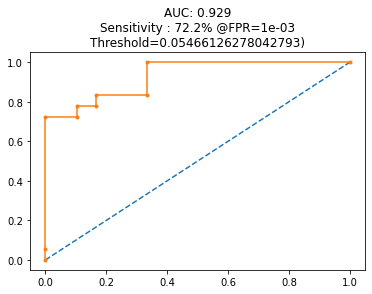

In [242]:
evaluate(embedding_model, images, label)